# Reproduce the Paper Figures (Level 1)
To reproduce the results:
1. place the `qmt_v52` and `qmt_v53` folders in the `data` folder (downloaded from Figshare).
2. run this notebook top to bottom.

In [1]:
import project_path

import matplotlib.pyplot as plt
from copy import deepcopy
import os
import re
import json
import ast
import string
import pandas as pd
import seaborn as sns
import sqlite3 as sl
from tqdm import tqdm
from typing import List, Any, Tuple, Dict
import pathlib

from lib.detectors import KS_Detector
from lib.inspector import Inspector
from lib.inspector import OneNightStandInspector
from lib.qmt import execute_programs
from lib.utils import iterate_over
from lib.utils import load_config_and_check
from lib.inspector import retrieve_relevant_file_paths
from lib.inspector import inspec_column_of
from lib.inspector import read_program
from lib.inspector import create_folder_in_interesting_cases
from lib.inspector import copy_bug

%load_ext autoreload
%autoreload 2

In [2]:
# define constants
OUT_FOLDER = "../data/paper_images"
COL_TRANSF = "followup.metamorphic_transformations"
PVAL_COL = "divergence.ks.p-value"
ALPHA_LEVEL = 0.05
EXP_FOLDERS_QDIFF = ["qmt_v52"]
EXP_FOLDERS_MORPHQ = ["qmt_v53"]

ALL_MR_NAMES = [
    "AddUnusedRegister",
    "ChangeBackend",
    "ChangeCouplingMap",
    "ChangeOptLevel",
    "ChangeQubitOrder",
    "ChangeTargetBasis",
    "InjectNullEffect",
    "InjectParameters",
    "RunIndependentPartitions",
    "ToQasmAndBack",
    "QdiffG1SwapToCnot",
    "QdiffG2TwoHToId",
    "QdiffG3XToHSSH",
    "QdiffG4ZtoSS",
    "QdiffG5CZtoHCnotH",
    "QdiffG6TwoCzToId",
    "QdiffG7CCNOTDecomposition"
]

MR_ALIAS = {
    "ChangeTargetBasis": "ChangeOfGateSet",
    "ToQasmAndBack": "Roundtrip conversion via QASM",
    "ChangeBackend": "Change of backend",
    "ChangeCouplingMap": "Change of coupling map",
    "ChangeOptLevel": "Change of optimization level",
    "ChangeTargetBasis": "Change of gate set",
    "ChangeQubitOrder": "Change of qubit order",
    "RunIndependentPartitions": "Partitioned execution",
    "InjectNullEffect": "Inject null-effect operations",
    "AddUnusedRegister": "Add quantum register",
    "InjectParameters": "Inject parameters",
}

# create OUT_FOLDER if it does not exist
pathlib.Path(OUT_FOLDER).mkdir(parents=True, exist_ok=True)

# Read Data
Read the experimental data produced from the evaluation of MorphQ (and QDiff-Transformations).
This includes:
- the coverage achieved by the two approaches, 
- the number of crashes detected 
- the number of divergences spotted.

In [3]:
def read_coverage(experiment_name: str):
    """Read the coverage information for the given experiment.
    
    Return:
    - df_coverage: pd.DataFrame with columns
        "n_programs": int number of programs run so far.
        "percent_covered": float percentage code coverage corresponding to 
        the n_programs
        "exp_name": str repeated experiment_name
    Note that the two array will have the same size.        
    """
    exp_path = os.path.join("..", "data", experiment_name, "coverage_reports")
    cov_reports = os.listdir(exp_path)
    reports = []
    for cov_report in cov_reports:
        c_report = {}
        c_report["experiment_name"] = experiment_name
        path_report = os.path.join(exp_path, cov_report)
        c_report["n_programs"] = int(cov_report.replace(".json", ""))
        report_data = json.load(open(path_report, 'r'))
        c_report["percent_covered"] = report_data["totals"]["percent_covered"]
        reports.append(c_report)
    return pd.DataFrame.from_records(reports).sort_values(by="n_programs")


def read_data_and_warnings(experiment_name: str):
    """Read the datase of the warnings found during the experiment."""
    sql_path = os.path.join("..", "data", experiment_name, "qfl.db")
    sql_conn = sl.connect(sql_path)
    # LOAD DATA
    df_data = pd.read_sql("""SELECT * from QFLDATA""", sql_conn)
    df_data["experiment_name"] = experiment_name
    print(f"Total (potentially divergent) comparisons: {len(df_data)}")
    try:
        df_crash = pd.read_sql("""SELECT * from CRASHDATA""", sql_conn)
        print(f"Total crash in programs: {len(df_crash)}")
        print(f"\tcrashing source: {len(df_crash[~df_crash['exceptions.source'].isna()])}")
        print(f"\tcrashing follow-up: {len(df_crash[~df_crash['exceptions.followup'].isna()])}")
        df_crash["experiment_name"] = experiment_name
    except Exception as e:
        df_crash = pd.DataFrame()
        print("No crash data")
    
    return df_data, df_crash

In [4]:
df_all_cov = []
df_all_data = []
df_all_crash = []
    
for approach, exp_folders in zip(
        ["qdiff", "morphq"],
        [EXP_FOLDERS_QDIFF, EXP_FOLDERS_MORPHQ]):
    for exp_folder in exp_folders:
        print("-" * 80)
        print("Approach:", approach)
        df_cov = read_coverage(experiment_name=exp_folder)
        df_cov["approach"] = approach
        df_data, df_crash = read_data_and_warnings(experiment_name=exp_folder)
        df_data["approach"] = approach
        df_crash["approach"] = approach
        df_all_cov.append(df_cov)        
        df_all_data.append(df_data)
        df_all_crash.append(df_crash) 

# aggregate all data
df_data_both = pd.concat(df_all_data, axis=0).reset_index()
df_crash_both = pd.concat(df_all_crash, axis=0).reset_index()
df_generated_programs_both = pd.concat(
    [
        df_data_both.assign(generated_a_crash=False),
        df_crash_both.assign(generated_a_crash=True)
    ],
    axis=0
)

# specify the QDiff warnings
n_warinings_qdiff = len(df_generated_programs_both[
    (df_generated_programs_both["generated_a_crash"] == True) &
    (df_generated_programs_both["approach"] == "qdiff")
])
print("-" * 80)
print(f"Qdiff found {n_warinings_qdiff} warnings")

--------------------------------------------------------------------------------
Approach: qdiff
Total (potentially divergent) comparisons: 51271
No crash data
--------------------------------------------------------------------------------
Approach: morphq
Total (potentially divergent) comparisons: 6417
Total crash in programs: 1943
	crashing source: 0
	crashing follow-up: 1943
--------------------------------------------------------------------------------
Qdiff found 0 warnings


# RQ 1: MorphQ and QDiff-Transf Statistics - Table 2
Generate the statistics used in the paper and the latex table.

**MORPHQ Stats**

In [5]:
INCLUDE_DISTRIB_DIFF = True

print('MORPHQ')
df_morphq = df_generated_programs_both[
    df_generated_programs_both["approach"] == "morphq"
]
df_morphq = df_morphq.drop_duplicates(subset=["program_id"])
df_morphq_crash = df_morphq[df_morphq["generated_a_crash"]]
df_morphq_no_crash = df_morphq[~df_morphq["generated_a_crash"]]

print(f"In the first 2 days we tested {len(df_morphq)} program pairs")

n_tot_pairs = len(df_morphq)
n_crash = len(df_morphq_crash)
n_complete_execution = len(df_morphq_no_crash)
assert n_crash + n_complete_execution == n_tot_pairs

perc_crash = (n_crash / n_tot_pairs) * 100
perc_complete_execution = (n_complete_execution / n_tot_pairs) * 100

print(f"{n_crash} ({perc_crash:.2f} %) crashes")
print(f"{n_complete_execution} ({perc_complete_execution:.2f} %) complete executions")

n_crash_source = len(df_morphq_crash[~df_morphq_crash['exceptions.source'].isna()])
n_crash_followup = len(df_morphq_crash[~df_morphq_crash['exceptions.followup'].isna()]) 
perc_crash_source = (n_crash_source / n_tot_pairs) * 100
perc_crash_followup = (n_crash_followup / n_tot_pairs) * 100

n_divergence = len(df_morphq[
    (df_morphq[PVAL_COL] < ALPHA_LEVEL) & 
    (df_morphq["exceptions.followup"].isnull())
])
perc_divergence = (n_divergence / n_tot_pairs) * 100

print("% RQ1 " + str(EXP_FOLDERS_MORPHQ))
print("\\newcommand{\percCrashesBenchmark}{"+f"{perc_crash:.1f}"+"\%}")
print("\\newcommand{\\totalTestedProgramPairs}{"+f"{n_tot_pairs:,.0f}"+"}")
print("\\newcommand{\\totalTestedProgramPairsAbbr}{"+f"{n_tot_pairs/1000:.0f}k"+"}")

if INCLUDE_DISTRIB_DIFF:
    print("\\newcommand{\\totalPairsWithDistrDifference}{"+f"{n_divergence:,.0f}"+"}")
    divergent_pairs_text = """
  \hspace{3em} $\hookrightarrow$ Distribution differences & """ + f"{n_divergence:,.0f} & {perc_divergence:.1f} \\%"+ """\\\\
    """
else:
    divergent_pairs_text = ""

print("""
\\begin{table}[t]
  \centering
  % """ + str(EXP_FOLDERS_MORPHQ) + """
  \caption{Distribution of warnings produced over two days.}
  \\begin{tabular}{@{}lrr@{}}
  \\toprule
  & Number & Percentage \\\\
  \\midrule
  Tested program pairs& """ + f"{n_tot_pairs:,.0f}"+ """& 100.0\\% \\\\
  \hspace{1em} $\hookrightarrow$ Crashes in source program & """ + f"{n_crash_source:,.0f} & {perc_crash_source:.1f} \\%"+ """\\\\
  \hspace{1em} $\hookrightarrow$ Crashes in follow-up program & """ + f"{n_crash_followup:,.0f} & {perc_crash_followup:.1f} \\%"+ """\\\\
  \hspace{1em} $\hookrightarrow$ Successful executions & """ + f"{n_complete_execution:,.0f} & {perc_complete_execution:.1f} \\%"+ """\\\\
  """ + f"{divergent_pairs_text}" + """
\\bottomrule
  \end{tabular}
  \label{tab:warnings_distribution}
\end{table}
""")

MORPHQ
In the first 2 days we tested 8360 program pairs
1943 (23.24 %) crashes
6417 (76.76 %) complete executions
% RQ1 ['qmt_v53']
\newcommand{\percCrashesBenchmark}{23.2\%}
\newcommand{\totalTestedProgramPairs}{8,360}
\newcommand{\totalTestedProgramPairsAbbr}{8k}
\newcommand{\totalPairsWithDistrDifference}{56}

\begin{table}[t]
  \centering
  % ['qmt_v53']
  \caption{Distribution of warnings produced over two days.}
  \begin{tabular}{@{}lrr@{}}
  \toprule
  & Number & Percentage \\
  \midrule
  Tested program pairs& 8,360& 100.0\% \\
  \hspace{1em} $\hookrightarrow$ Crashes in source program & 0 & 0.0 \%\\
  \hspace{1em} $\hookrightarrow$ Crashes in follow-up program & 1,943 & 23.2 \%\\
  \hspace{1em} $\hookrightarrow$ Successful executions & 6,417 & 76.8 \%\\
  
  \hspace{3em} $\hookrightarrow$ Distribution differences & 56 & 0.7 \%\\
    
\bottomrule
  \end{tabular}
  \label{tab:warnings_distribution}
\end{table}



**QDiff-Transformations Stats**

In [6]:
INCLUDE_DISTRIB_DIFF = True

print('QDIFF')
df_qdiff = df_generated_programs_both[
    df_generated_programs_both["approach"] == "qdiff"
]
df_qdiff = df_qdiff.drop_duplicates(subset=["program_id"])
df_qdiff_crash = df_qdiff[df_qdiff["generated_a_crash"]]
df_qdiff_no_crash = df_qdiff[~df_qdiff["generated_a_crash"]]

print(f"In the first 2 days we tested {len(df_qdiff)} program pairs")

n_tot_pairs = len(df_qdiff)
n_crash = len(df_qdiff_crash)
n_complete_execution = len(df_qdiff_no_crash)
assert n_crash + n_complete_execution == n_tot_pairs

perc_crash = (n_crash / n_tot_pairs) * 100
perc_complete_execution = (n_complete_execution / n_tot_pairs) * 100

print(f"{n_crash} ({perc_crash:.2f} %) crashes")
print(f"{n_complete_execution} ({perc_complete_execution:.2f} %) complete executions")

n_crash_source = len(df_qdiff_crash[~df_qdiff_crash['exceptions.source'].isna()])
n_crash_followup = len(df_qdiff_crash[~df_qdiff_crash['exceptions.followup'].isna()]) 
perc_crash_source = (n_crash_source / n_tot_pairs) * 100
perc_crash_followup = (n_crash_followup / n_tot_pairs) * 100

n_divergence = len(df_qdiff[
    (df_qdiff[PVAL_COL] < ALPHA_LEVEL) & 
    (df_qdiff["exceptions.followup"].isnull())
])
perc_divergence = (n_divergence / n_tot_pairs) * 100

print("% RQ1 " + str(EXP_FOLDERS_QDIFF))
print("\\newcommand{\percCrashesBenchmark}{"+f"{perc_crash:.1f}"+"\%}")
print("\\newcommand{\\totalTestedProgramPairs}{"+f"{n_tot_pairs:,.0f}"+"}")
print("\\newcommand{\\totalTestedProgramPairsAbbr}{"+f"{n_tot_pairs/1000:.0f}k"+"}")

if INCLUDE_DISTRIB_DIFF:
    print("\\newcommand{\\totalPairsWithDistrDifference}{"+f"{n_divergence:,.0f}"+"}")
    divergent_pairs_text = """
  \hspace{3em} $\hookrightarrow$ Distribution differences & """ + f"{n_divergence:,.0f} & {perc_divergence:.1f} \\%"+ """\\\\
    """
else:
    divergent_pairs_text = ""
print("""
\\begin{table}[t]
  \centering
  % """ + str(EXP_FOLDERS_QDIFF) + """
  \caption{Distribution of warnings produced over two days.}
  \\begin{tabular}{@{}lrr@{}}
  \\toprule
  & Number & Percentage \\\\
  \\midrule
  Tested program pairs& """ + f"{n_tot_pairs:,.0f}"+ """& 100.0\\% \\\\
  \hspace{1em} $\hookrightarrow$ Crashes in source program & """ + f"{n_crash_source:,.0f} & {perc_crash_source:.1f} \\%"+ """\\\\
  \hspace{1em} $\hookrightarrow$ Crashes in follow-up program & """ + f"{n_crash_followup:,.0f} & {perc_crash_followup:.1f} \\%"+ """\\\\
  \hspace{1em} $\hookrightarrow$ Successful executions & """ + f"{n_complete_execution:,.0f} & {perc_complete_execution:.1f} \\%"+ """\\\\
  """ + f"{divergent_pairs_text}" + """
\\bottomrule
  \end{tabular}
  \label{tab:warnings_distribution}
\end{table}
""")

QDIFF
In the first 2 days we tested 51271 program pairs
0 (0.00 %) crashes
51271 (100.00 %) complete executions
% RQ1 ['qmt_v52']
\newcommand{\percCrashesBenchmark}{0.0\%}
\newcommand{\totalTestedProgramPairs}{51,271}
\newcommand{\totalTestedProgramPairsAbbr}{51k}
\newcommand{\totalPairsWithDistrDifference}{528}

\begin{table}[t]
  \centering
  % ['qmt_v52']
  \caption{Distribution of warnings produced over two days.}
  \begin{tabular}{@{}lrr@{}}
  \toprule
  & Number & Percentage \\
  \midrule
  Tested program pairs& 51,271& 100.0\% \\
  \hspace{1em} $\hookrightarrow$ Crashes in source program & 0 & 0.0 \%\\
  \hspace{1em} $\hookrightarrow$ Crashes in follow-up program & 0 & 0.0 \%\\
  \hspace{1em} $\hookrightarrow$ Successful executions & 51,271 & 100.0 \%\\
  
  \hspace{3em} $\hookrightarrow$ Distribution differences & 528 & 1.0 \%\\
    
\bottomrule
  \end{tabular}
  \label{tab:warnings_distribution}
\end{table}



**MORPHQ Program Diversity**

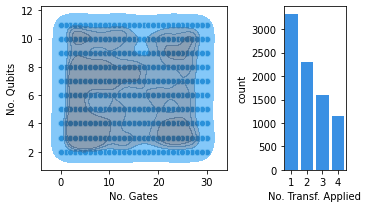

In [7]:
df = df_generated_programs_both.copy()

# disable pandas warning: SettingWithCopyWarning
pd.options.mode.chained_assignment = None

df_generated_programs_morphq_w_no_MR = df[df["approach"] == "morphq"]

df_generated_programs_morphq_w_no_MR["ast_list_MR"] = \
    df_generated_programs_morphq_w_no_MR[COL_TRANSF].apply(ast.literal_eval)
df_generated_programs_morphq_w_no_MR["no_MR_applied"] = \
    df_generated_programs_morphq_w_no_MR["ast_list_MR"].apply(lambda e: len(list(e)))

df_generated_programs_morphq_w_no_MR = df_generated_programs_morphq_w_no_MR.reset_index(drop=True)

df = df_generated_programs_both.copy()

df_generated_programs_morphq = df[df["approach"] == "morphq"]
df_generated_programs_morphq.keys()

# creates figures with 1:4 width ratio, grid 1x2
fig, axes = plt.subplots(
    nrows=1, ncols=2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(5, 3))

ax_mr = axes[1]
ax_bits_vs_ops = axes[0]

sns.countplot(
    data=df_generated_programs_morphq_w_no_MR,
    x="no_MR_applied",
    color='dodgerblue',
    ax=ax_mr
)
ax_mr.set_xlabel("No. Transf. Applied")


sns.scatterplot(
    data=df_generated_programs_morphq,
    x='source.n_ops',
    y='source.n_qubits',
    ax=ax_bits_vs_ops
)
sns.kdeplot(
    data=df_generated_programs_morphq,
    x='source.n_ops',
    y='source.n_qubits',
    levels=5,
    fill=True,
    alpha=0.6,
    cut=2,
    ax=ax_bits_vs_ops,
)

ax_bits_vs_ops.set_ylabel("No. Qubits")
ax_bits_vs_ops.set_xlabel("No. Gates")
plt.tight_layout()
fig.savefig(os.path.join(OUT_FOLDER, "dataset_stats.pdf"), bbox_inches = 'tight')


# RQ 1: Clustering of MorphQ Crashes - Figure 9
Cluster the warnings produced by MorphQ with a regex-based approach.
The clustering is stored in a configuration file in the `config` folder.

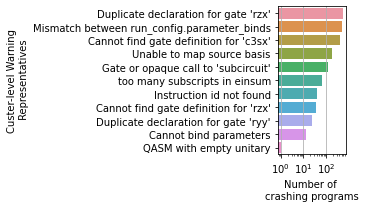

In [8]:
CLUSTERING_CONFIG = "cluster_v01"
from lib.inspector import cluster_warnings

cluster_config = load_config_and_check(
    f"../config/clustering/{CLUSTERING_CONFIG}.yaml")

df_crash_clustered = cluster_warnings(
    df=df_crash_both,
    warning_col="exceptions.followup",
    cluster_config=cluster_config,  
)
fig, ax = plt.subplots(figsize=(5, 3))
sns.countplot(
    data=df_crash_clustered,
    y="short_desc",
    order=df_crash_clustered["short_desc"].value_counts().index,
    ax=ax)
ax.set_ylabel("Custer-level Warning\n Representatives")
ax.set_xlabel("Number of \ncrashing programs")
ax.grid(axis='x')
ax.set_xscale('log')
plt.tight_layout()
fig.savefig(os.path.join(OUT_FOLDER, "warning_manual_clustering_categories.pdf"))

# RQ2 - Real-World Bugs Found - Table 3
Reproduce the table with bugs used in the paper, these  data are taken from a manually filled spreadsheet, saved as CSV.

In [9]:
# create latex table
PATH_DATASET = "../miscellanea/table_artifacts/Qiskit_Bug_Dataset - main_dataset.csv"
df_bugs = pd.read_csv(PATH_DATASET)
df_bugs = df_bugs.sort_values(by=[
    "status", "known_before"
], ascending=[True, False])
df_bugs = df_bugs.reset_index(drop=True)
df_bugs = df_bugs.reset_index(drop=False)
df_bugs = df_bugs.fillna("-")

ANONYMOUS = False
KEEP_ONLY_CONFIRMED = True 
KEEP_ONLY_CRASHES = True 
REMOVE_FALSE_POSITIVES = True

col_renaming = {
    "index": "ID",
    "link_to_issue": "Report",
    "status": "Status",
    "known_before": "Novelty",
    #"API_usage": "API usage",
    #"manifestation": "How",
    "crash_category": "Crash message",
    "mr_used": "Metamorphic transformations",
    #"bug_description": "Description",
    #"root_cause": "Root Cause",
}

if ANONYMOUS:
    df_bugs["link_to_issue"] = "#XXXX"
else:
    df_bugs["link_to_issue"] = df_bugs["link_to_issue"].apply(
        lambda e: e.replace("https://github.com/Qiskit/qiskit-terra/issues/", "#")
    )

df_bugs["known_before"] = df_bugs["known_before"].apply(
    lambda e: str(e).replace("duplicate (different manifestation)", "duplicate")
)

pd.set_option('display.max_colwidth', 1000)

relevant_columns = col_renaming.keys()
df_table = deepcopy(df_bugs)
if KEEP_ONLY_CRASHES:
    df_table = df_table[df_table["manifestation"] == "crash"]
if REMOVE_FALSE_POSITIVES:
    df_table = df_table[~(df_table["status"] == "false positive")]
df_table = df_table.drop(columns='index')  

def replace_MR_names(transf_str):
    new_transf_str = transf_str
    for k, v in MR_ALIAS.items():
        new_transf_str = new_transf_str.replace(k, v)
    return new_transf_str

df_table["mr_used"] = df_table["mr_used"].apply(
    lambda e: replace_MR_names(transf_str=e)
) 
df_table = df_table.reset_index(drop=True)
df_table = df_table.reset_index(drop=False)
df_table = df_table[relevant_columns].rename(columns=col_renaming)
df_table["ID"] = df_table["ID"].apply(lambda e: int(e) + 1)
df_table.head()

print("% RQ2")
for i, row in df_table.iterrows():
    msg = row["Crash message"]
    msg = msg.translate(str.maketrans('', '', string.punctuation))
    msg = ''.join([w.capitalize() for w in msg.lower().split()])
    msg = ''.join(ch for ch in msg if ch.isalpha())
    if msg != "":
        print("\\newcommand{\\ID" + msg + "}{" + str(row["ID"]) + "}")

print("")
table_code = df_table.to_latex(
    column_format='@{}rlllp{5cm}p{7.3cm}@{}',
    index=False)
table_code = re.sub("\s'", " `", table_code)
print(table_code)


% RQ2
\newcommand{\IDQargsNotInThisCircuit}{1}
\newcommand{\IDTooManySubscriptsInEinsumNumpy}{2}
\newcommand{\IDGateOrOpaqueCallToSubcircuit}{3}
\newcommand{\IDDuplicateDeclarationForGateRzx}{4}
\newcommand{\IDInstructionIdNotFound}{5}
\newcommand{\IDMismatchBetweenParameterbinds}{6}
\newcommand{\IDCannotFindGateDefinitionForCsx}{7}
\newcommand{\IDCannotBindParametersNotPresentInTheCircuit}{8}
\newcommand{\IDQasmGateDefinitionWithNoOperands}{9}
\newcommand{\IDCannotFindGateDefinitionForRzx}{10}
\newcommand{\IDDuplicateDeclarationForGateRyy}{11}
\newcommand{\IDCannotFindGateDefinitionForUnitary}{12}
\newcommand{\IDCannotFindGateDefinitionForRcccx}{13}

\begin{tabular}{@{}rlllp{5cm}p{7.3cm}@{}}
\toprule
 ID & Report &    Status &   Novelty &                                     Crash message &                                                                Metamorphic transformations \\
\midrule
  1 &  \#7694 & confirmed &       new &                         qargs not in this circuit &    

<ipython-input-9-d94bbc7c7a6e>:75: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table_code = df_table.to_latex(


# RQ3: QDiff vs MorphQ 

## Coverage (QDiff vs MorphQ )
Compute the coverage for both approaches showing how it evolves over time.

\newcommand{\coverageQDiff}{6.12}
\newcommand{\coverageMorphQ}{8.10}


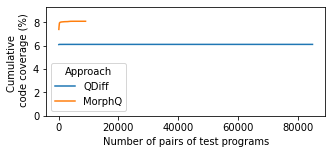

In [10]:
fig, ax = plt.subplots(figsize=(5, 2))

df_cov_both = pd.concat(df_all_cov, axis=0).reset_index()
df_cov_both = df_cov_both.rename(columns={"approach": "Approach"})
df_cov_both["Approach"] = df_cov_both["Approach"].map(
    {"qdiff": "QDiff", "morphq": "MorphQ"}
)

coverage_qdiff = df_cov_both[df_cov_both["Approach"] == "QDiff"]["percent_covered"].max()
coverage_morphq = df_cov_both[df_cov_both["Approach"] == "MorphQ"]["percent_covered"].max()
print("\\newcommand{\\coverageQDiff}{"+f"{coverage_qdiff:,.2f}"+"}")
print("\\newcommand{\\coverageMorphQ}{"+f"{coverage_morphq:,.2f}"+"}")

sns.lineplot(
    data=df_cov_both,
    x="n_programs",
    y="percent_covered",
    hue="Approach"
)
ax.set_ylabel("Cumulative \n code coverage (%)")
ax.set_xlabel("Number of pairs of test programs")
max_val = df_cov_both["percent_covered"].max()
ax.set_ylim(0, max_val * 1.15)
#ax.set_xscale('log')

fig.savefig(os.path.join(OUT_FOLDER, "coverage_morphq_vs_qdiff.pdf"))

## No. Warnings (QDiff vs MorphQ )

QDiff brings no crash...
% comparison with qdiff
\newcommand{\totalCrashesMorphQ}{1,943}
\newcommand{\totalCrashesQDiff}{0}


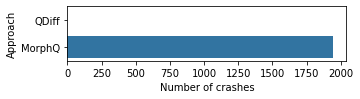

In [11]:
fig, ax = plt.subplots(figsize=(5, 1))
sns.countplot(
    data=df_crash_both,
    y="approach",
    ax=ax
)
ax.set_yticks(range(2))
ax.set_yticklabels(labels=["MorphQ", "QDiff"])

ax.set_ylim(-.5, 1.5)
ax.set_ylabel("Approach")
ax.set_xlabel("Number of crashes")
print("QDiff brings no crash...")

print("% comparison with qdiff")

total_crashes_morphq = len(df_crash_both[
    df_crash_both["approach"] == "morphq"
])
total_crashes_qdiff = len(df_crash_both[
    df_crash_both["approach"] == "qdiff"
])

print("\\newcommand{\\totalCrashesMorphQ}{"+f"{total_crashes_morphq:,.0f}"+"}")
print("\\newcommand{\\totalCrashesQDiff}{"+f"{total_crashes_qdiff:,.0f}"+"}")

# RQ 4: Contribution of Metamorphic Transformations - Figure 13

--------------------------------------------------------------------------------
Stats with 4 MR applied.
Percentage of programs containing at least one of these transformations and leading to a crash:
- Change of gate set: 53.760445682451255 %
- Roundtrip conversion via QASM: 71.99312714776632 %
- Change of backend: 40.25974025974026 %
- Change of coupling map: 41.84914841849148 %
- Change of optimization level: 38.53211009174312 %
- Change of qubit order: 19.696969696969695 %
- Partitioned execution: 0.0 %
- Inject null-effect operations: 50.187265917603 %
- Add quantum register: 47.40740740740741 %
- Inject parameters: 57.14285714285714 %
--------------------------------------------------------------------------------
Stats with 3 MR applied.
Percentage of programs containing at least one of these transformations and leading to a crash:
- Change of gate set: 38.125 %
- Roundtrip conversion via QASM: 66.25 %
- Change of backend: 27.288135593220336 %
- Change of coupling map: 28.32980

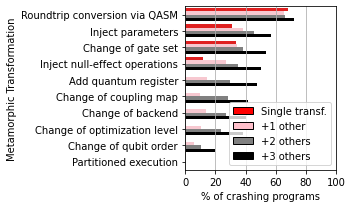

In [12]:
relevant_columns = [
    "program_id",
    "generated_a_crash",
    "exceptions.followup",
    "approach",
    COL_TRANSF,
    PVAL_COL
]
# disable pandas warning: SettingWithCopyWarning
pd.options.mode.chained_assignment = None

df = df_generated_programs_both[relevant_columns]
df.loc[:, COL_TRANSF] = df[COL_TRANSF].apply(ast.literal_eval)
df.loc[:, COL_TRANSF] = df[COL_TRANSF].apply(lambda e: list(set(e)))
df_flat = df.explode(COL_TRANSF)

def assign_class(row):
    if row["generated_a_crash"]:
        return "Crash diff."
    else:
        if row[PVAL_COL] < ALPHA_LEVEL:
            return "Distrib. diff."
    return "Same"

def assign_class_short(row):
    if row["generated_a_crash"]:
        return "C"
    else:
        if row[PVAL_COL] < ALPHA_LEVEL:
            return "D"
    return "S"


df_flat["Execution comparison"] = df_flat.apply(
    lambda row: assign_class(row),
    #lambda row: assign_class_short(row),
    axis=1
)

df_flat[COL_TRANSF] = df_flat[COL_TRANSF].apply(
    lambda e: MR_ALIAS[e] if e in MR_ALIAS.keys() else e
)


# save a list of all programs in the four categories

map_no_MR_to_prog_ids = {}

for i in range(1, 5):
    programs_with_i_MR = df_generated_programs_morphq_w_no_MR[
        df_generated_programs_morphq_w_no_MR["no_MR_applied"] == i
    ]["program_id"].unique()
    map_no_MR_to_prog_ids[i] = list(programs_with_i_MR)

from matplotlib.patches import Patch

#fig, axes = plt.subplots(1, 4, figsize=(7, 3), sharey=True)

COLORS = ['black', 'gray', 'pink', 'red']
LEGENDS = ['+3 others', '+2 others', '+1 other', 'Single transf.']
legend_elements = [
      Patch(facecolor=color, edgecolor='black', label=text)
      for color, text in list(zip(COLORS, LEGENDS))[::-1]
]

all_records = []

#for i in range(4):
for color, n_transf in zip(
        COLORS,
        range(4, 0, -1)):
    print("-" * 80)
    print(f"Stats with {n_transf} MR applied.")
    print("Percentage of programs containing at least one of these transformations and leading to a crash:")
    ids_prog_to_consider = map_no_MR_to_prog_ids[n_transf]
    
    
    # compute the contributions per each MR
    map_mr_crash_perc = {}

    df_morphq_flat = df_flat[df_flat["approach"] == "morphq"]
    df_morphq_flat = df_morphq_flat[
        df_morphq_flat["program_id"].isin(ids_prog_to_consider)
    ]
    
    for mr_name in MR_ALIAS.values():
        df = df_morphq_flat
        df_c_mr = df[df["followup.metamorphic_transformations"] == mr_name]
        n_all_program_id = len(df_c_mr["program_id"].unique())    
        n_crashing_program_ids = len(df_c_mr[
            df_c_mr["Execution comparison"] == "Crash diff."
        ]["program_id"].unique())
        if n_all_program_id > 0 :
            perc_c_mr = (float(n_crashing_program_ids) / n_all_program_id) * 100
            print(f"- {mr_name}: {perc_c_mr} %")
            map_mr_crash_perc[mr_name] = perc_c_mr
    
    # plot 
    labels, perc = zip(*[
        (k, v) 
        for k, v in sorted(map_mr_crash_perc.items(), key=lambda item: item[1])])

    
    for label, p in zip(labels, perc):
        
        all_records.append({
            "perc": p,
            "label": label,
            "n_transf": n_transf
        })
df_mutli_transf_hist = pd.DataFrame.from_records(all_records)


fig, ax = plt.subplots(1, 1, figsize=(5, 3), sharey=True)

order = df_mutli_transf_hist[
    df_mutli_transf_hist["n_transf"] == 4
].sort_values(by="perc", ascending=False)["label"].values

sns.barplot(
    x="perc", hue="n_transf", y="label", 
    data=df_mutli_transf_hist,
    order=order,
    palette=sns.color_palette(["#ff0000", "#ffc0cb", "#808080", "#000000"]),
    ax=ax
)

ax.grid(axis='x')
ax.set_xlim(0, 100)
ax.set_ylabel("Metamorphic Transformation")
ax.set_xlabel("% of crashing programs")
ax.legend(handles=legend_elements, loc='best')

axes[0].set_ylabel("Metamorphic Relationship")
#axes.set_xlabel("% of crashing programs\nwith the given transformation")
plt.tight_layout()

fig.savefig(os.path.join(OUT_FOLDER, "contribution_of_mr_perc_crashes_no_MR_applied.pdf"))

# RQ5 Time Cost per Component - Figure 14
Here we compute the time cost per component for both approaches.

['MorphQ' 'QDiff Transf.']
% RQ3
\newcommand{\avgTimeMsGenerationAndTransf}{163.6}
\newcommand{\avgTimeMsGenerationOnly}{6.0}
\newcommand{\avgTimeMsTransfOnly}{157.7}


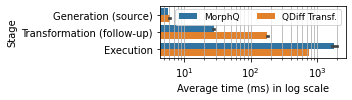

In [13]:
relevant_time_cols = [
    'program_id',
    'time_exec',
    'source.time_generation',
    #'followup.time_generation', # this attribute is statically copied form source
    'followup.time_metamorph',
    #'divergence.ks.time',
    'generated_a_crash',
    'approach'
]

#df_time = df_morphq[relevant_time_cols]
df_time = df_generated_programs_both[relevant_time_cols]
df_time_melt = pd.melt(
    df_time, id_vars=['program_id', 'generated_a_crash', 'approach'], 
    value_vars=relevant_time_cols.remove('program_id'))
df_time_melt["value"] = df_time_melt["value"].apply(lambda e: 1000 * e)
fig, ax = plt.subplots(figsize=(5, 1.5))

mapping = {
    "source.time_generation": 'Generation (source)',
    "followup.time_metamorph": 'Transformation (follow-up)',
    "time_exec": "Execution",
    #"divergence.ks.time": "Divergence Check"
}

df = df_time_melt
df["approach"] = df["approach"].apply(lambda x: "QDiff Transf." if x == "qdiff" else x)
df["approach"] = df["approach"].apply(lambda x: "MorphQ" if x == "morphq" else x)
df.sort_values(by="approach", inplace=True)

sns.barplot(
    data=df,
    y='variable',
    x='value',
    hue='approach',
    order=list(mapping.keys()),
    ax=ax
)
print(df["approach"].unique())

print("% RQ3")
avg_ms_gen_and_transf = df_time_melt[df_time_melt["variable"].isin([
    "source.time_generation", 
    "followup.time_metamorph"]
)].groupby(by="program_id").sum().reset_index()["value"].mean()
print("\\newcommand{\\avgTimeMsGenerationAndTransf}{" + f"{avg_ms_gen_and_transf:.1f}" + "}")

avg_ms_gen_only = df_time_melt[
    df_time_melt["variable"] == "source.time_generation"].reset_index()["value"].mean()
print("\\newcommand{\\avgTimeMsGenerationOnly}{" + f"{avg_ms_gen_only:.1f}" + "}")
avg_ms_transf_only = df_time_melt[
    df_time_melt["variable"] == "followup.time_metamorph"].reset_index()["value"].mean()
print("\\newcommand{\\avgTimeMsTransfOnly}{" + f"{avg_ms_transf_only:.1f}" + "}")

original_labels = ax.get_yticklabels()
ax.set_yticklabels(labels=[
    mapping.get(e._text, e._text)
    for e in original_labels
])
ax.grid(axis='x', which='both')
ax.set_xscale('log')
ax.set_ylabel('Stage')
ax.set_xlabel('Average time (ms) in log scale')
ax.legend(loc='upper right', ncol=2, fontsize=9, bbox_to_anchor=(1, 1.04))
plt.tight_layout()
#ax.legend().set_visible(False)
fig.savefig(os.path.join(OUT_FOLDER, "RQ4_time_analysis.pdf"))